# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

---
## Import

In [2]:
# Utilities相關函式庫
import os
import pickle
import random
from glob import glob

# 多為向量處理相關函式庫
import numpy as np

# 數據分析相關函式庫
import pandas as pd

# 圖像處理相關函式庫
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 深度學習相關函式庫
import tensorflow as tf
from sklearn.utils import shuffle

## Step 0: Load The Data
**Set related settings and parameters**

In [3]:
ROOT_DIR = os.getcwd()

DATA_DIR = os.path.join(ROOT_DIR, 'data')

# TODO: Fill this in based on where you saved the training and testing data
signnames_file = os.path.join(ROOT_DIR, 'signnames.csv')
training_file = os.path.join(DATA_DIR, 'train.p')
validation_file= os.path.join(DATA_DIR, 'valid.p')
testing_file = os.path.join(DATA_DIR, 'test.p')

**Load Data**

In [4]:
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [27]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
df = pd.read_csv(signnames_file)

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = df.shape[0]

id_to_labels = df.SignName

labels_to_id = {labels: i for i, labels in df.values}

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

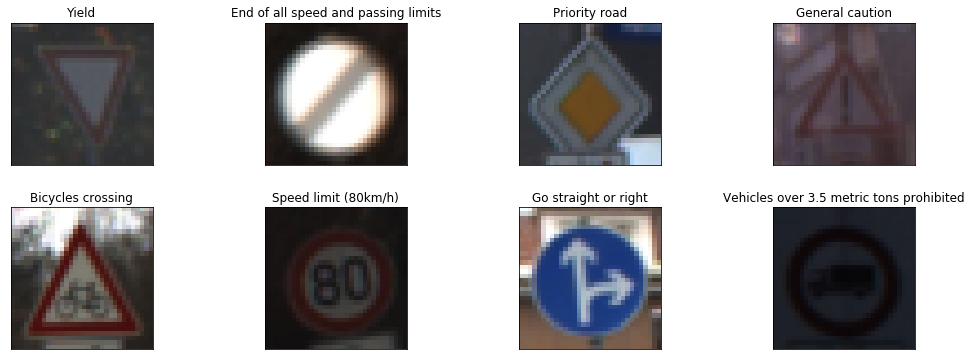

In [6]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

### TODO: 每個classes數量值方圖

In [ ]:
def images_visualize(images, labels):
    fig, axes = plt.subplots(2, 4, figsize=(18, 6), 
                             subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.3, wspace=0.05)
    for i, ax, label in zip(range(len(labels)), axes.flat, labels):
        ax.imshow(images[i])
        ax.set_title(id_to_labels[label])
    return
X_train, y_train = shuffle(X_train, y_train)
images_visualize(X_train[500:508], y_train[500:508])

----
## Step 3:Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

**shuffle**

In [7]:
X_train, y_train = shuffle(X_train, y_train)

**normalization**

In [8]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
X_train = (X_train / 255.).astype('float32')
X_valid = (X_valid / 255.).astype('float32')
X_test  = (X_test  / 255.).astype('float32')

---
## Step 3: Design and Test a Model Architecture

**fully connected layer**

In [9]:
def add_fc_layer(inputs, out_size, n_layer=0, mean=0, stddev=0.1,activation_function=None):
    # add one more layer and return the output of this layer
    layer_name = 'dnn_layer%s' % n_layer
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            Weights = tf.Variable(tf.truncated_normal((inputs.shape[1].value, out_size), mean=mean, stddev=stddev), name='W')
            tf.summary.histogram(layer_name + '/weights', Weights)
            
        with tf.name_scope('biases'):
            biases = tf.Variable(tf.zeros([1, out_size]) + 0.1, name='b')
            tf.summary.histogram(layer_name + '/biases', biases)
            
        with tf.name_scope('Wx_plus_b'):
            Wx_plus_b = tf.add(tf.matmul(inputs, Weights), biases)
            
        if activation_function is None:
            outputs = Wx_plus_b
        else:
            outputs = activation_function(Wx_plus_b, )
        tf.summary.histogram(layer_name + '/outputs', outputs)
    return outputs

**convolutional layer**

In [10]:
def add_cnn_layer(inputs, filters=64, kernel_size=[5,5], strides=[1,1,1,1], padding='VALID', \
                  n_layer=0, mean=0, stddev=0.1, activation_function=None):
    
    layer_name = 'cnn_layer{}'.format(n_layer)
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights = tf.Variable(tf.truncated_normal((kernel_size[0], kernel_size[1], inputs.shape[3].value, filters), 
                                                   mean=mean, stddev=stddev), name='W')
            tf.summary.histogram(layer_name + '/weights', weights)

        with tf.name_scope('biases'):
            biases = tf.Variable(tf.random_normal([filters]), name='b')
            tf.summary.histogram(layer_name + '/biases', biases)

        with tf.name_scope('conv'):
            conv = tf.nn.conv2d(inputs, weights, strides=strides, padding=padding) + biases

        if activation_function is None:
            outputs = conv
        else:
            outputs = activation_function(conv, )
        # tf.summary.histogram(layer_name + '/outputs', outputs)

    return outputs

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

**Placeholder**

In [11]:
with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 32, 32, 3), name='x_input')
    y = tf.placeholder(tf.int32, (None), name='y_input')
    one_hot_y = tf.one_hot(y, n_classes)

**Model Architecture**

In [12]:
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

conv_layer1 = add_cnn_layer(x, filters=32, kernel_size=[5,5], padding='SAME', n_layer=1, activation_function=tf.nn.relu)
conv_layer1 = tf.nn.max_pool(conv_layer1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  

conv_layer2 = add_cnn_layer(conv_layer1, filters=32, kernel_size=[3,3], padding='SAME', n_layer=2, activation_function=tf.nn.relu)
conv_layer3 = add_cnn_layer(conv_layer2, filters=32, kernel_size=[3,3], padding='SAME', n_layer=3, activation_function=tf.nn.relu)
conv_layer3 = tf.nn.max_pool(conv_layer3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

conv_layer4 = add_cnn_layer(conv_layer3, filters=64, kernel_size=[3,3], padding='SAME', n_layer=4, activation_function=tf.nn.relu)
conv_layer5 = add_cnn_layer(conv_layer4, filters=128, kernel_size=[3,3], padding='SAME', n_layer=5, activation_function=tf.nn.relu)
conv_layer5 = tf.nn.max_pool(conv_layer5, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

conv_layer6 = add_cnn_layer(conv_layer5, filters=256, kernel_size=[3,3], padding='SAME', n_layer=6, activation_function=tf.nn.relu)
conv_layer6 = tf.nn.max_pool(conv_layer6, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

fc_layer1 = tf.layers.flatten(conv_layer6)

# TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
fc_layer2 = add_fc_layer(inputs=fc_layer1, out_size=256, n_layer=1, activation_function=tf.nn.relu)

# TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
fc_layer3 = add_fc_layer(inputs=fc_layer2, out_size=128, n_layer=2, activation_function=tf.nn.relu)

# TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
logits = add_fc_layer(inputs=fc_layer3, out_size=n_classes, n_layer=3)

**Loss Function & Optimizer**

In [13]:
rate = 0.0015

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

with tf.name_scope('Loss'):
    loss_operation = tf.reduce_mean(cross_entropy)

with tf.name_scope('Adam'):
    training_operation = tf.train.AdamOptimizer(learning_rate = rate, 
                                                beta1=0.9, 
                                                beta2=0.999, 
                                                epsilon=1e-08).minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



**Model Evaluation**

In [14]:
with tf.name_scope('Accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

---
## Step 4:Training the Model

In [15]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

EPOCHS = 50
BATCH_SIZE = 128

# Create a summary to monitor cost tensor
tf.summary.scalar("Loss", loss_operation)
# Create a summary to monitor training accuracy tensor
tf.summary.scalar("Accuracy", accuracy_operation)

# Merge all summaries into a single op
merged = tf.summary.merge_all()


saver = tf.train.Saver()
bestest_accuracy = 0
with tf.Session() as sess:
    # Run the initializer
    sess.run(tf.global_variables_initializer())
    
    # op to write logs to Tensorboard    
    train_writer = tf.summary.FileWriter("logs/" + '/train', sess.graph)
    test_writer = tf.summary.FileWriter("logs/" + '/valid')
    
    num_examples = len(X_train)
    one_epochs_step = int(num_examples / BATCH_SIZE) + 1
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        X_valid, y_valid = shuffle(X_valid, y_valid)
        for j, offset in enumerate(range(0, num_examples, BATCH_SIZE)):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            _, summary = sess.run([training_operation, merged], feed_dict={x: batch_x, y: batch_y})
            train_writer.add_summary(summary, i * one_epochs_step + j)
            if j % 50 == 0:
                loss, summary = sess.run([loss_operation, merged], feed_dict={x: X_valid, y: y_valid})
                # Write logs at every iteration
                test_writer.add_summary(summary, i * one_epochs_step + j)
        
        # Print Accuracy
        validation_accuracy = evaluate(X_valid, y_valid)            
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        if validation_accuracy > bestest_accuracy:
            saver.save(sess, './lenet')
            bestest_accuracy = validation_accuracy
        print("Model saved")
        print()

Training...

EPOCH 1 ...
Validation Accuracy = 0.549
Model saved

EPOCH 2 ...
Validation Accuracy = 0.805
Model saved

EPOCH 3 ...
Validation Accuracy = 0.824
Model saved

EPOCH 4 ...
Validation Accuracy = 0.847
Model saved

EPOCH 5 ...
Validation Accuracy = 0.862
Model saved

EPOCH 6 ...
Validation Accuracy = 0.865
Model saved

EPOCH 7 ...
Validation Accuracy = 0.883
Model saved

EPOCH 8 ...
Validation Accuracy = 0.900
Model saved

EPOCH 9 ...
Validation Accuracy = 0.891
Model saved

EPOCH 10 ...
Validation Accuracy = 0.894
Model saved

EPOCH 11 ...
Validation Accuracy = 0.883
Model saved

EPOCH 12 ...
Validation Accuracy = 0.898
Model saved

EPOCH 13 ...
Validation Accuracy = 0.890
Model saved

EPOCH 14 ...
Validation Accuracy = 0.915
Model saved

EPOCH 15 ...
Validation Accuracy = 0.916
Model saved

EPOCH 16 ...
Validation Accuracy = 0.913
Model saved

EPOCH 17 ...
Validation Accuracy = 0.907
Model saved

EPOCH 18 ...
Validation Accuracy = 0.915
Model saved

EPOCH 19 ...
Validation 

---

## Step 5: Test a Model on New Images

### Load and Output the Images

**Read 8 images download from website and resize those into 32x32**

In [16]:
path = os.path.join(ROOT_DIR, 'web_images')
web_images_path = glob(path + '/*.jpg')
web_images = np.array([cv2.resize(plt.imread(path), (32,32)) for path in web_images_path])
web_images_id = [int(os.path.split(web_images_path[i].split('.')[0])[1]) for i in range(len(web_images_path))]

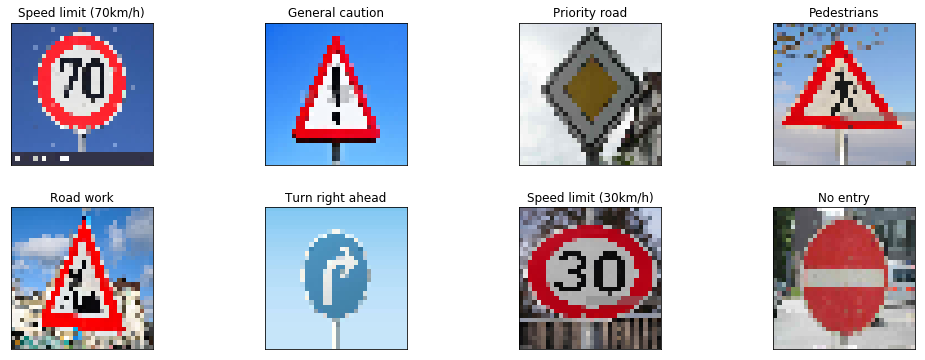

In [17]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
images_visualize(web_images, web_images_id)

### Predict the Sign Type for Each Image

In [18]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()
predict = tf.nn.softmax(logits)

# normalization
web_images = (web_images / 255.).astype('float32')

sess = tf.Session()

# Load the weights and bias
saver.restore(sess, './lenet')
predict = sess.run(predict, feed_dict={x: web_images})
predict_max = np.argmax(predict, axis=1)


INFO:tensorflow:Restoring parameters from ./lenet


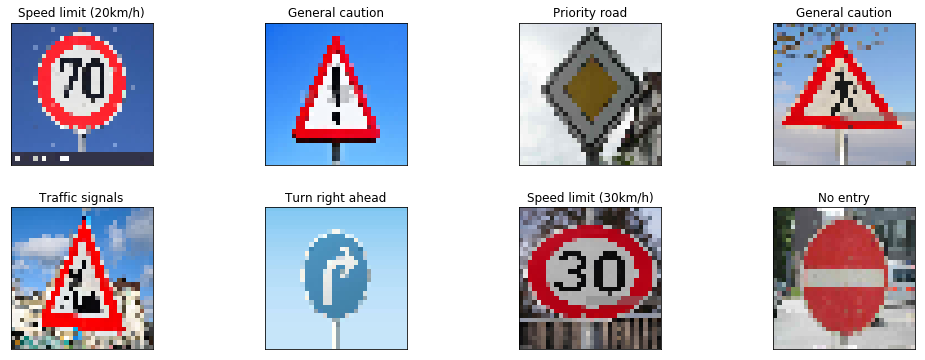

In [19]:
images_visualize(web_images, predict_max)

### Analyze Performance

In [20]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
accurate = (np.sum(predict_max == web_images_id) / 8) * 100
print('The 8 images accurate is {}%'.format(accurate))

The 8 images accurate is 62.5%


### Testing from test dataset

The 8 images accurate is 100.0%


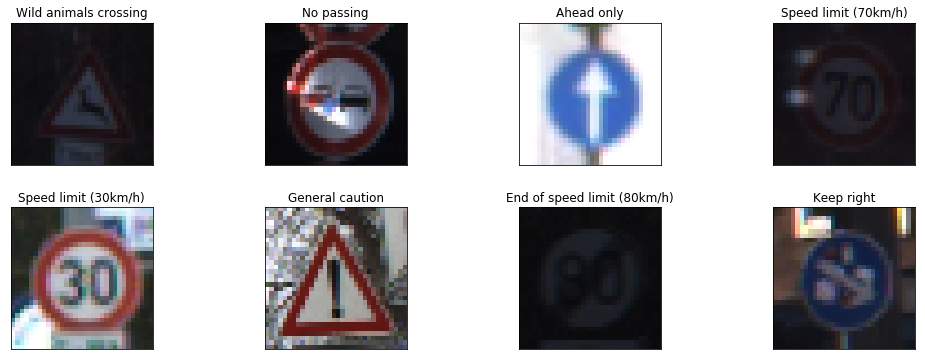

In [21]:
test_data_rand = [random.randint(0,len(X_test)) for i in range(8)]
predict = tf.nn.softmax(logits)
predict = sess.run(predict, feed_dict={x: X_test[test_data_rand]})
predict_max = np.argmax(predict, axis=1)
images_visualize(X_test[test_data_rand], predict_max)
accurate = (np.sum(predict_max == y_test[test_data_rand]) / 8) * 100
print('The 8 images accurate is {}%'.format(accurate))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [22]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
sess.run(tf.nn.top_k(predict, k=5))

TopKV2(values=array([[  1.00000000e+00,   4.28724417e-12,   2.38078166e-13,
          1.48229831e-13,   3.58519197e-14],
       [  1.00000000e+00,   1.00397943e-14,   2.20478853e-20,
          9.55045448e-21,   1.14662894e-21],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  9.99871731e-01,   1.07061765e-04,   1.78492774e-05,
          1.57644433e-06,   4.16085271e-07],
       [  1.00000000e+00,   3.65882287e-16,   1.63281549e-17,
          2.42676775e-19,   8.90078457e-20],
       [  1.00000000e+00,   2.65132432e-08,   8.18285061e-20,
          2.72189476e-21,   2.20651216e-21],
       [  9.99981165e-01,   1.20232717e-05,   6.45320779e-06,
          1.60611819e-07,   6.99808567e-08],
       [  9.99417543e-01,   3.11775890e-04,   1.59753370e-04,
          4.19918761e-05,   3.00605661e-05]], dtype=float32), indices=array([[31, 21,  2,  5, 23],
       [ 9, 35, 28,  2, 15],
       [35,  0,  1,  2,  3],
       [ 4,  8,  1

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 6 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [23]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

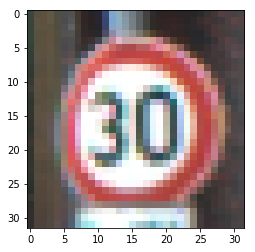

In [24]:
plt.imshow(X_test[1])

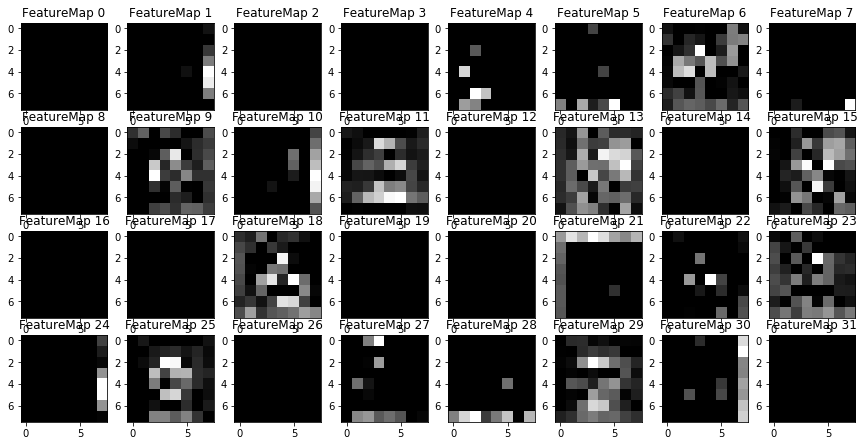

In [25]:
outputFeatureMap(X_test[1:2], conv_layer3)

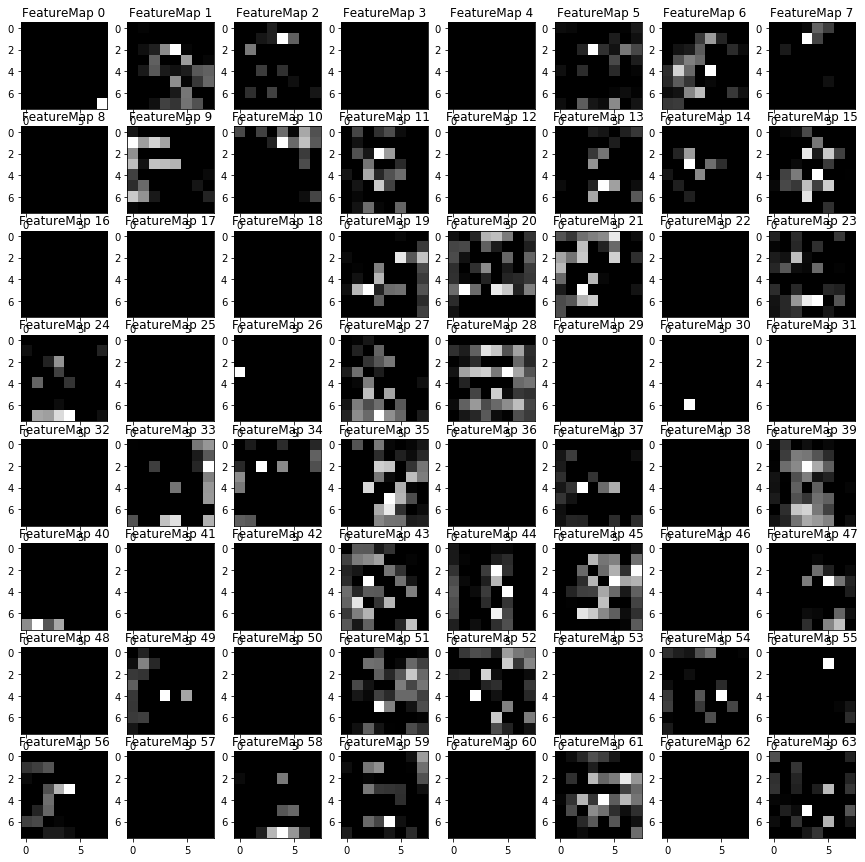

In [26]:
outputFeatureMap(X_test[1:2], conv_layer4)